# CROSS VALIDATION : THE CHOICE OF K 

<br>

## Introduction

<br>
Several studies compared different values of $k$ in k-fold cross validation, analyzing how the choice of this hyper-parameter affects the variance and the bias of the estimate. Unfortunately, there is no such thing as a free lunch; however, we are interested in finding a sweet spot, a value that seems to be a good trade-off between variance and bias in most cases.

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
from sklearn.model_selection import KFold
import sklearn.metrics as mtr

import preprocessing as pre
import utilcompute as uc
from pprint import pprint
import datetime


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = pre.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

splt_small = np.arange(2, 10 + 1, 1)
splt_medium = [12, 16, 20, 40, 60]
splt_large = [80, 100, 120]

n_splits = splt_small.tolist() + splt_medium + splt_large

print('k (# of folds) : ', n_splits)

k (# of folds) :  [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 20, 40, 60, 80, 100, 120]


In [10]:
columns = ['k', 'seed', 'iteration', 'err_train', 'err_test', 'time_ms']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

results_index = 0
seeds = range(1, 5 + 1, 1)

for k in n_splits:
    
    kf = KFold(n_splits = k, shuffle = False, random_state = None)
    
    for s in seeds :
        
        sample_perc = 0.8
        df_sampled = df.sample(frac = sample_perc, replace = False, random_state = s, axis = 0)        

        for k_index, (train_positions, test_positions) in enumerate(kf.split(X = df_sampled[features], y = df_sampled[target])) :

            #print('k : {0}   |   seed : {1}   |   k_index : {2}'.format(k, s, k_index))
        
            timer_start = datetime.datetime.now()

            fold_train = df_sampled.iloc[train_positions]   
            fold_test = df_sampled.iloc[test_positions]   

            #if (k_index == 0):
            #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
            #    print('test  indices : {0}'.format(fold_test.index.values))
            #    print()

            #model = lm.LogisticRegression()
            model = nbr.KNeighborsClassifier(n_neighbors = 5)
            model.fit(fold_train[features], fold_train[target])

            y_pred_train = model.predict(fold_train[features])
            y_pred_test = model.predict(fold_test[features])

            timer_stop = datetime.datetime.now()

            #metrics_train = uc.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train)
            #metrics_test = uc.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test)

            acc_train = mtr.accuracy_score(y_true = fold_train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
            acc_test = mtr.accuracy_score(y_true = fold_test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)

            values_dict = {
                'k' : k,
                'seed' : s,
                'iteration' : k_index + 1,            
                #'err_train' : 1 - metrics_train['ACC'],
                #'err_test' : 1 - metrics_test['ACC'],
                'err_train' : 1 - acc_train,
                'err_test' : 1 - acc_test,
                'time_ms' : (timer_stop - timer_start).microseconds / 1000
            }

            results_df.loc[results_index] = values_dict    
            results_index += 1

results_df = results_df.astype(dtype = 'float')
#print(results_df)


In [11]:
print()
print('train | err mean : ', results_df['err_train'].mean())
print('train | err std  : ', results_df['err_train'].std())

print()
print('test  | err mean : ', results_df['err_test'].mean())
print('test  | err std  : ', results_df['err_test'].std())



train | err mean :  0.03740033554158327
train | err std  :  0.014233874794684749

test  | err mean :  0.05051423695435882
test  | err std  :  0.17539889727223232


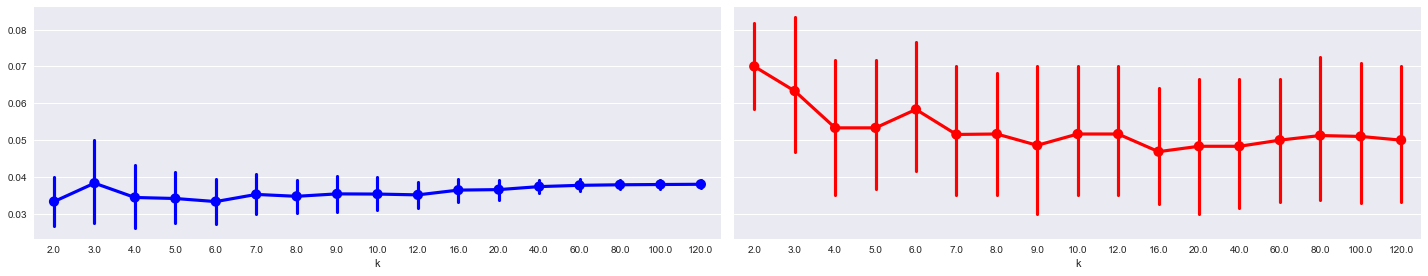

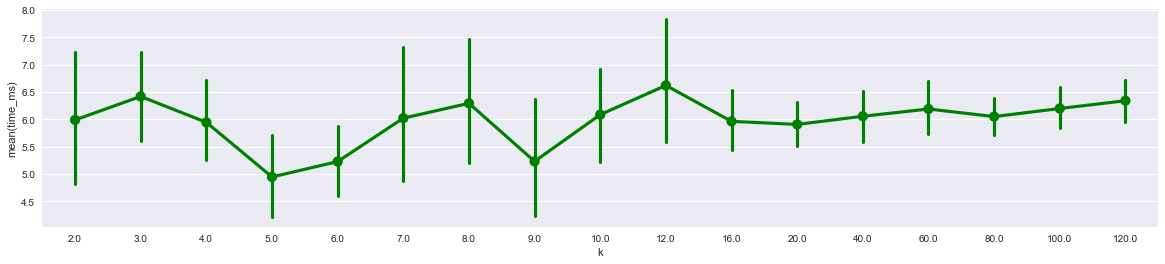

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2 , figsize=(20, 4), sharey = True)  

sns.pointplot(x = 'k', y = 'err_train', data = results_df, join = True, color = 'blue', ax = axs[0], label = 'err train')
axs[0].set_ylabel('')    
sns.pointplot(x = 'k', y = 'err_test', data = results_df, join = True, color = 'red', ax = axs[1], label = 'err test')
axs[1].set_ylabel('')  

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(nrows = 1, ncols = 1 , figsize=(20, 4))  
sns.pointplot(x = 'k', y = 'time_ms', data = results_df, join = True, color = 'green', label = 'time [ms]')
plt.show()

## Considerations

<br>
Let’s summarize the analysis of the bias-variance trade-off by listing the general trends <b>as the number of folds increases</b> :

<br>
<ul style="list-style-type:square">
    <li>
        the <b>bias decreases</b>; the performance estimator becomes more and more accurate with the size of the training set 
    </li>
    <br>
    <li>
        the <b>variance increases</b> too; large values of $k$ lead to high variability of the performance estimator due to the
        fact that the training set are extremely similar to one another; please keep in mind that the same behaviour can be
        observed for small values of $k$ (the model is sensitive to how the dataset is split). <br>
        <b>... why don't we see this pattern in the first two graphs ?</b>
    </li>
    <br>
    <li>
        the <b>computational cost increases</b>, due to more iterations and larger training sets to fit
    </li>
</ul>

<br>
Kohavi’s experiments on various real-world datasets suggest that <b>10-fold cross-validation offers the best trade-off between bias and variance</b>. Another usual value, especially for small datasets, is 5 (less expensive), although for such datasets we could also use LOOCV.

<br>
When the original dataset if of modest or small size, holding back a large part of data for model testing is ill-advised : this sort of fragmentation harms the model fitting to the extent that we won't have a trustworthy performace estimate anyway. Under such circumstances it is better to use all data for both training and testing through cross-validation.

<br>
As a rule of thumb, we can say that the pessimistic bias and large variance concerns are less problematic the larger the dataset. Moreover, it is not uncommon to repeat the k-fold cross-validation procedure with different random seeds in hope to obtain a more robust estimate. Please note that there is no point in repeating LOOCV, since LOOCV always produces the same splits.

<br>
Hold-out evaluation (and similar) is desirable over cross-validation when concerns arise about computational efficiency, if our dataset is sufficiently large. 


## References

<br>
<ul style="list-style-type:square">
    <li>
         Sebastian Raschka - 
         <a href="https://bit.ly/2LEwbSN">
         Model evaluation, model selection, and algorithm selection in machine learning - Part III</a>        
    </li>
</ul>